##### Homework 2

Due: Tuesday February 22, 11:59pm

Late deadline (50\% off): Thursday February 24, 11:59pm

Name: Jayaram Gokulan

NetID: jg929


## Instructions
Read through this python notebook. You will be asked questions and given programming tasks. These are numbered, followed by point values for grading (for example, "Question 17.8 (5pt)"). You should edit the notebook directly to input your solution code and question answers. You can double click on text to edit it, which you should use for putting your question answers in the notebook.

When you are ready to submit, you should run all of your code (click Cell->Run All). Then you should submit **three** files to gradescope:
* PDF: export to PDF (click File->Download as->PDF via LaTeX)
* .py: export to Python (click File->Download as->Python (.py))
* .ipynb: submit the edited Jupyter Notebook


# Core Probabilistic Routines
You will be using the following helper functions for manipulating probability distributions.

Recall from lecture that you should represent probabilities as the logarithm of the probability. Whenever you want to multiply probabilities, instead you just add the log probabilities. Whenever you want to add probabilities, instead you just `log_sum_exp` the log probabilities. Whenever you want to add a list of probabilities, instead you just `log_sum_exp_list` the list of log probabilities.

Generally in this homework we will be representing distributions over a random variable $X$ by dictionary mapping $x$ to $\log P(X=x)$. 

In [40]:
from math import exp, isinf
import math
import numpy as np
import matplotlib.pyplot as plt
from time import time


def log(x):
    if x==0.:
        return float("-inf")
    return math.log(x)

def sample_from_log_distribution(distribution):
    """
    distribution: a dictionary mapping x to log P(x)
    stochastically draws a sample from the distribution P(x)
    """
    distribution = list(distribution.items())
    values = [v for v, _ in distribution ]
    probabilities = np.array([exp(log_prob) for _, log_prob in distribution ])
    result = np.random.multinomial(1, probabilities)
    for v, r in zip(values, result):
        if r:
            return v
    
def log_sum_exp(first_log_probability, second_log_probability):
    """
    Returns log(exp(first_log_probability) + exp(second_log_probability))
    Does so in a numerically stable way
    """
    if isinf(first_log_probability) and first_log_probability<0:
        return second_log_probability
    if isinf(second_log_probability) and second_log_probability<0:
        return first_log_probability
    larger, smaller = max(first_log_probability, second_log_probability), min(first_log_probability, second_log_probability)
    return larger + log(1 + exp(smaller-larger))

def log_sum_exp_list(lst):
    """
    Returns log(sum(exp(log_probability) for log_probability in lst))
    Does so in a numerically stable way
    """
    total=float("-inf")
    for log_probability in lst:
        total = log_sum_exp(total, log_probability)
    return total

def norm_log_distribution(distribution):
    """
    distribution is a dictionary mapping x to log (alpha * P(x))
    where alpha is a normalization constant
    returns a dictionary mapping x to log P(x), ie a normalized distribution
    Does so in a numerically stable way
    """
    normalizer = log_sum_exp_list(list(distribution.values()))
    return {x: log_probability - normalizer
            for x, log_probability in distribution.items()}

def expectation(distribution, f):
    """
    f is a function from x to a real number
    distribution is a dictionary mapping x to log P(x)
    returns the expectation of f under the distribution P
    """
    return sum( f(x)*exp(log_probability)
                for x, log_probability in norm_log_distribution(distribution).items() )



# Alarm Network
You will be implementing and experimenting with the alarm network given in class, which is diagrammed below.
<center>
<img src="https://www.researchgate.net/profile/Alireza-Khanteymoori/publication/278673563/figure/fig1/AS:294244133687301@1447164676400/An-example-of-a-Bayesian-network.png" width="500">
</center>

First we represent the distribution over burglary with a dictionary mapping values of the burglary random variable to the log probability of that burglary value:

In [14]:
burglary_distribution = {True: log(0.001), False: log(1-0.001)}

Then we do the same thing for earthquake:

In [16]:
earthquake_distribution = {True: log(0.002), False: log(1-0.002)}

Because alarm is directly caused by burglary and earthquake, we represent its conditional distribution as a function that inputs burglary and earthquake. The `alarm_distribution` function returns the probability distribution over whether the alarm goes off, given those inputs.

In [17]:
def alarm_distribution(burglary, earthquake):
    if burglary and earthquake: return {True: log(0.95), False: log(1-0.95)}
    if burglary and not earthquake: return {True: log(0.94), False: log(1-0.94)}
    if not burglary and earthquake: return {True: log(0.29), False: log(1-0.29)}
    if not burglary and not earthquake: return {True: log(0.001), False: log(1-0.001)}

## Task 1.1 Defining the rest of the network (1pt)
Implement `mary_distribution` and `john_distribution`, which should be functions that take the setting of `alarm` (either `True` or `False`) and which return a dictionary mapping the setting of MaryCalls/JohnCalls (either `True` or `False`) to a log probability. This should be analogous to `alarm_distribution`.

In [19]:
def mary_distribution(alarm):
    if alarm: return {True: log(0.70), False: log(1-0.70)}
    else:  return {True: log(0.01), False: log(1-0.01)}
def john_distribution(alarm):
    if alarm: return {True: log(0.90), False: log(1-0.90)}
    else:  return {True: log(0.05), False: log(1-0.05)}

## Task 1.2 Defining the joint distribution (2pt)
Implement `log_joint`. Its arguments are settings of the random variables (`burglary`, `earthquake`, `alarm`, `mary`, `john`). It should return the logarithm of the joint probability of that variable assignment: 
$$\log P(\text{Burglary=burglary, Earthquake=earthquake, Alarm=alarm, MaryCalls=mary, JohnCalls=john})$$

Your implementation of `log_joint` should use `burglary_distribution`, `earthquake_distribution`, `alarm_distribution`, `mary_distribution`, and `john_distribution`.

In [21]:
def log_joint(burglary, earthquake, alarm, mary, john):
    return burglary_distribution[burglary]+earthquake_distribution[earthquake]+alarm_distribution(burglary, earthquake)[alarm]+mary_distribution(alarm)[mary]+john_distribution(alarm)[john]

## Task 1.3 Calculate $\log P(\text{Mary=True, John=True})$ (2pt)
Using `log_sum_exp_list` and `log_joint`, calculate $\log P(\text{Mary=True, John=True})$.
Store this calculation result in the variable `mary_and_john`.

Hint: you might want to try a *list comprehension* that looks like:

`[ ... for burglary in [True, False] for earthquake in [True, False] for alarm in [True, False] ]`

Alternatively you could use three nested `for` loops to iterate over all possible variable assignments to earthquake, burglary, and alarm.

In [23]:
mary_and_john = log_sum_exp_list([log_joint(burglary, earthquake, alarm, True, True) for burglary in [True, False] for earthquake in [True, False] for alarm in [True, False]]) # implement as part of homework; fill in None
print("P(John=True, Mary=True) =", exp(mary_and_john))

P(John=True, Mary=True) = 0.0020841002390000014


## Task 1.4 More calculations (2pt)
Similarly, calculate $\log P(\text{Burglar=True, Mary=True, John=True})$ and $\log P(\text{Burglar=False, Mary=True, John=True})$. Put these quantities into the variables `burglary_and_mary_and_john` and `not_burglary_and_mary_and_john`.

In [24]:
burglary_and_mary_and_john = log_sum_exp_list([log_joint(True, earthquake, alarm, True, True) for earthquake in [True, False] for alarm in [True, False]]) # implement as part of homework; fill in None
not_burglary_and_mary_and_john = log_sum_exp_list([log_joint(False, earthquake, alarm, True, True) for earthquake in [True, False] for alarm in [True, False]]) # implement as part of homework; fill in None
print("log P(Burglar=True, John=True, Mary=True) =", burglary_and_mary_and_john)
print("log P(Burglar=False, John=True, Mary=True) =", not_burglary_and_mary_and_john)

log P(Burglar=True, John=True, Mary=True) = -7.4315942266119235
log P(Burglar=False, John=True, Mary=True) = -6.507733191269771


## Task 1.5 Calculate posterior $P(\text{Burglar=True}|\text{Mary=True, John=True})$ (1pt)
Write down a single line of code which will calculate and print out $P(\text{Burglar=True}|\text{Mary=True, John=True})$. You should reuse `burglary_and_mary_and_john` and `mary_and_john`.
Hint: Use Bayes rule to relate $P(\text{Burglar=True}|\text{Mary=True, John=True})$ to $P(\text{Burglar=True}, \text{Mary=True, John=True})$ and $P(\text{Mary=True, John=True})$.

In [25]:
print("P(Burglar=True|John=True, Mary=True) =", exp(burglary_and_mary_and_john)/exp(mary_and_john)) # implement as part of homework; fill in None

P(Burglar=True|John=True, Mary=True) = 0.28417183536439283


In [26]:
print("P(Burglar=False|John=True, Mary=True) =", exp(not_burglary_and_mary_and_john)/exp(mary_and_john)) # implement as part of homework; fill in None

P(Burglar=False|John=True, Mary=True) = 0.7158281646356074


## Task 1.6 Another calculation for $P(\text{Burglar=True}|\text{Mary=True, John=True})$ (2pt)
Construct an unnormalized distribution over Burglar, conditioned on both Mary and John calling.
Store this inside the variable `unnormalized_log_posterior`, which should be a dictionary. The dictionary entry `unnormalized_log_posterior[b]` should be the logarithm of a probability that is proportional to $P(\text{Burglar=b} | \text{Mary=True, John=True})$.

Normalize this distribution (`unnormalized_log_posterior`) by calling `norm_log_distribution`, and store the result inside a new variable called `log_posterior`.
The dictionary entry `log_posterior[b]` should be the logarithm of $P(\text{Burglar=b}| \text{Mary=True, John=True})$.

In [27]:
unnormalized_log_posterior = {True: burglary_and_mary_and_john, False: not_burglary_and_mary_and_john}  # implement as part of homework
log_posterior = norm_log_distribution(unnormalized_log_posterior) # implement as part of homework
print("log P(Burglar|John=True, Mary=True) =", log_posterior)
print("P(Burglar=True|John=True, Mary=True) =", exp(log_posterior[True]))

log P(Burglar|John=True, Mary=True) = {True: -1.258176169692387, False: -0.3343151343502342}
P(Burglar=True|John=True, Mary=True) = 0.2841718353643928


Noticed that you have now calculated $P(\text{Burglar=True}|\text{Mary=True, John=True})$ twice, in two different ways. You should get the same result both times.

## Explaining Away

### Task 1.7 Programming (1pt)
Calculate and print out $P(\text{Burglar=True}|\text{Mary=True, John=True, Earthquake=True})$. 

In [28]:
burglary_and_mary_and_john_and_earthquake = log_sum_exp_list([log_joint(True, True, alarm, True, True)  for alarm in [True, False]]) # implement as part of homework; fill in None
mary_and_john_and_earthquake = log_sum_exp_list([log_joint(burglary, True, alarm, True, True)  for burglary in [True, False] for alarm in [True, False]])

print("P(Burglar=True|Mary=True, John=True, Earthquake=True) =", 
      exp(burglary_and_mary_and_john_and_earthquake)/exp(mary_and_john_and_earthquake)) # implement as part of homework; fill in None

P(Burglar=True|Mary=True, John=True, Earthquake=True) = 0.0032622416021499314


### Question 1.8 (1pt)
Why did the probability of burglary go down given Mary and John calling, after we conditioned on the earthquake happening?

* Since we know that alarm is caused only by two factors i.e. burgalary and earthquake. Alarm causes only two effects ie Mary calling and John calling. Since it was observed that Mary and John was calling, we infer that alarm is be true and since we also assume earthquake to be true in the above case, this will explain away Burgalary being a causal factor for the alarm to be true which is why we see $P(\text{Burglar=True}|\text{Mary=True, John=True, Earthquake=True})$ becoming lower than $P(\text{Burglar=True}|\text{Mary=True, John=True})$


# Hidden Markov Model

You will be implementing and experimenting with the Hidden Markov Model (HMM) given in class, which is diagrammed below.

<center>
<img src="https://www.cs.cornell.edu/~ellisk/res/hmm.png" width="800">

</center>

The next Jupyter Notebook cell contains an implementation of Hidden Markov Model in the class `HMM`. You will be filling out parts of this implementation.

## Task 2.1 Simulating from the Bayesian Network (5pt)
Implement `sample_from_model`. You should use the method `sample_observation_given_state` for drawing from $P(X_t|Z_t)$, and the function `sample_from_log_distribution` for drawing from $P(Z_{t+1}|Z_{t})$ and for drawing from $P(Z_{1})$.

**You should first sample from $P(Z_{1})$, then $P(X_1|Z_1)$, then $P(Z_{2}|Z_{1})$, then $P(X_2|Z_2)$, then $P(Z_{3}|Z_{2})$, then $P(X_{3}|Z_{3})$, etc.** You could sample in other orders, but please do it in this order so that your results are identical to the reference results.
 

## Task 2.2 Calculating the forward distribution $P(Z_t|X_{1:t})$ (10pt)

Implement the forward algorithm for calculating $P(Z_t|X_{1:t})$. Do so within the method `forward`, and implement the API described in the docstring (*remember to calculate log probabilities, and your solution should linear time*)

## Task 2.3 Calculating the backward distribution $P(X_{t+1:T}|Z_t)$ (10pt)

Implement the backward algorithm for calculating $P(X_{t+1:T}|Z_t)$. Do so within the method `backward`, and implement the API described in the docstring (*remember to calculate log probabilities, and your solution should linear time*)

## Task 2.4 Calculating the forward/backward (smoothing) distribution $P(Z_t|X_{1:T})$ (5pt)

Implement the forward/backward algorithm for calculating $P(Z_t|X_{1:T})$. Do so within the method `forward_backward`, and implement the API described in the docstring (*remember to calculate log probabilities, and your solution should linear time*)

## Calculating the marginal likelihood $P(X_{1:T})$

### Task 2.5.1  (10pt)
Derive an expression for $P(X_{1:T})$ in terms of $P(Z_1)$, $P(X_1|Z_1)$, and the "backward" distribution $P(X_{2:T} | Z_1)$.
Write down the resulting equation for $P(X_{1:T})$.

**Your equation here (doubleclick on Jupyter notebook box to edit):** 
* $$P(X_{1:T})=\sum_{Z_1}P(X_{2:T} | Z_1)*P(Z_1)*P(X_1|Z_1)$$

### Task 2.5.2 (5pt)
Implement the `marginal_likelihood` method of `HMM`, which calculates $\log P(X_{1:T})$. You should use the equation that you derived in the previous part, together with your implementation of `backward`.

In [41]:
class HMM:
    def __init__(self, state_space, transition_distribution, initial_state_distribution):
        """
        state_space: list of possible values that each hidden state (Z_t) can assume
        transition_distribution: representation of log P(Z_{t+1} | Z_t).
           Should be a dictionary of dictionaries where:
           `transition_distribution[state_t][state_{t+1}] = log P(Z_{t+1}=state_{t+1} | Z_{t}=state_t)`
        initial_state_distribution: representation of log P(Z_1).
           Should be a dictionary where `initial_state_distribution[state_1] = log P(Z_1=state_1)`
        """
        self.state_space, self.transition_distribution, self.initial_state_distribution =\
             state_space, transition_distribution, initial_state_distribution

        normalizing_constant = log_sum_exp_list(list(initial_state_distribution.values()))
        if abs(normalizing_constant)>1e-5:
            assert False, f"Your initial state distribution is not normalized. Remembered that it should contain log probabilities."

        for s in state_space:
            normalizing_constant = log_sum_exp_list([self.transition_distribution[s][next_state]
                                                     for next_state in state_space])
            if abs(normalizing_constant)>1e-5:
                assert False,    "Your transition distribution is not normalized. Remembered that it should contain log probabilities. It is not normalized for state {s}"
        

        self.forward_dynamic_programming = {}
        self.backward_dynamic_programming = {}
        
    
    
    def logProb_observation_given_state(self, observation, state):
            """
            calculates log P(X_t=observation | Z_t=state)
            """
            pass
            #assert False, "should be defined by the class inheriting from HMM"

    def sample_observation_given_state(self, state):
            """
            stochastically draws a sample from P(X_t | Z_t=state)
            """
            pass
            #assert False, "should be defined by the class inheriting from HMM"

    def sample_from_model(self, time_steps):
            """
            Returns a sample from the generative model, not conditioned on anything
            The sample consists of both a list of observations and a list of hidden states
            Both of these lists should have length `time_steps`
            Return the pair (Z_{1:T}, X_{1:T})

            You should call out to the method `sample_observation_given_state`, 
              which will be implemented by classes inheriting from HMM

            ***You should first sample from $P(Z_{1})$, then $P(X_1|Z_1)$,
                                       then $P(Z_{2}|Z_{1})$, then $P(X_2|Z_2)$, 
                                       then $P(Z_{3}|Z_{2})$, then $P(X_{3}|Z_{3})$, 
                                       etc.
            You could sample in other orders, but please do it in this order!
            This ensures that your results are identical to the reference results.***
            """
            Zlist=[]
            Xlist=[]
            Z_1 = sample_from_log_distribution(self.initial_state_distribution)
            X_1 = self.sample_observation_given_state(Z_1)
            Zlist.append(Z_1)
            Xlist.append(X_1)
            Z_tprior = Z_1
            for i in range(time_steps):          
                Z_tnext = sample_from_log_distribution(self.transition_distribution[Z_tprior])
                X_tnext = self.sample_observation_given_state(Z_tnext)
                Zlist.append(Z_tnext)
                Xlist.append(X_tnext) 
                Z_tprior = Z_tnext
            #print("Zlist is",Zlist)
            #print("Xlist is", Xlist)
            return Zlist, Xlist    

    def forward(self, observations):
            """
            Returns log P(Z_t=s | X_{1:t}), where observations is a list containing X_{1:t} and t=len(observations)
            This distribution is returned by a dictionary mapping `s` to log P(Z_t=s | X_{1:t})
            If you do your dynamic programming via memoization+recursion, please use `self.forward_dynamic_programming`
            """
            #print("first obs:",observations[0])
            #if isinstance(observations[0],tuple):
            self.forward_dynamic_programming[1]={}
            for s in self.state_space:
                self.forward_dynamic_programming[1][s] = self.observation_distribution[s][observations[0]] + self.initial_state_distribution[s]

            for i in range(2,len(observations)+1):
                self.forward_dynamic_programming[i]={}
                for s in self.state_space:
                        self.forward_dynamic_programming[i][s] = log_sum_exp_list([(self.observation_distribution[s][observations[i-1]] + self.transition_distribution[Z_iminus][s] + self.forward_dynamic_programming[i-1][Z_iminus]) for Z_iminus in self.state_space]) 
            return self.forward_dynamic_programming[len(observations)]              
            #else:
                #self.forward_dynamic_programming[1]={}
                #for s in self.state_space:
                    #self.forward_dynamic_programming[1][s] = self.observation_distribution(s,observations[0]) + self.initial_state_distribution[s]

                #for i in range(2,len(observations)+1):
                    #self.forward_dynamic_programming[i]={}
                    #for s in self.state_space:
                            #self.forward_dynamic_programming[i][s] = log_sum_exp_list([(self.observation_distribution(s,observations[i-1]) + self.transition_distribution[Z_iminus][s] + self.forward_dynamic_programming[i-1][Z_iminus]) for Z_iminus in self.state_space]) 
                #return self.forward_dynamic_programming[len(observations)]
            # assert False, "implement as part of homework"

    def backward(self, observations):
            """
            Returns `log P(X_{t+1:T} | Z_t=s)`, for each state `s`,
               where `observations` is a list containing X_{t+1:T}, and observations[i]=X_{i+1+t}
            Concretely, return a dictionary mapping `s` to log P(X_{t+1:T} | Z_t=s)
            If you do your dynamic programming via memoization+recursion, please use `self.backward_dynamic_programming`
            (Note that this is not a distribution over Z_t--what you return should not necessarily be normalized)
            """
            #print("Backward first obs:",observations[0])
            #if isinstance(observations[0],tuple):
            self.backward_dynamic_programming[len(observations)+1]={}
            for s in self.state_space:
                    self.backward_dynamic_programming[len(observations)+1][s] = 0

            for i in range(len(observations),0,-1):
                self.backward_dynamic_programming[i]={}
                for s in self.state_space:
                        self.backward_dynamic_programming[i][s] = log_sum_exp_list([(self.observation_distribution[Z_iplus][observations[i-1]]  + self.transition_distribution[s][Z_iplus] + self.backward_dynamic_programming[i+1][Z_iplus]) for Z_iplus in self.state_space]) 
            return self.backward_dynamic_programming[1]
            #else:
            #self.backward_dynamic_programming[len(observations)+1]={}
            #for s in self.state_space:
                #self.backward_dynamic_programming[len(observations)+1][s] = 0

            #for i in range(len(observations),0,-1):
                #self.backward_dynamic_programming[i]={}
                #for s in self.state_space:
                    #self.backward_dynamic_programming[i][s] = log_sum_exp_list([(self.observation_distribution(Z_iplus,observations[i-1])  + self.transition_distribution[s][Z_iplus] + self.backward_dynamic_programming[i+1][Z_iplus]) for Z_iplus in self.state_space]) 
            #return self.backward_dynamic_programming[1]
            #assert False, "implement as part of homework"

    def forward_backward(self, observations, time):
            """
            Returns log P(Z_t | X_{1:T}), where t is one-indexed (starts counting at 1)
            The input variable `time` is t
            The list `observations` is equal to X_{1:T}
            So, 1<=time<=len(observations)
            The returned distribution should be represented by a dictionary mapping state `s` to log P(Z_t=s | X_{1:T})

            A Python array slicing tip:
               observations[:time] will extract the first `time` elements of `observations`
               observations[time:] will drop the first `time` elements of `observations`
            These satisfy:
               observations == observations[:time]+observations[time:]

            This should be a straightforward method to implement:
               it should just call your forward and backward methods and do a small amount of computation after that
            """
            smoothing={}
            for s in self.state_space:
                    smoothing[s] = self.backward(observations[time:])[s] + self.forward(observations[:time])[s]

            return norm_log_distribution(smoothing)
            #assert False, "implement as part of homework"

    def marginal_likelihood(self, observations):
            """
            Returns log P(observations)
            """  
            marginal =  log_sum_exp_list([(self.backward(observations[1:])[Z_1]+ self.observation_distribution(Z_1,observations[0]) + self.initial_state_distribution[Z_1]) for Z_1 in self.state_space])

            return marginal
            #assert False, "implement as part of homework"


# Spatial Tracker Model

You will be working with a HMM for spatial 2D tracking on a grid world. The grid has dimensions $\text{size}\times\text{size}$.

The hidden state at each time point is the true location of the moving object:
$$Z_t\in \{(x, y) \,|\,x\in 0...(\text{size}-1), \,y\in 0...(\text{size}-1)\}$$

The observation at each time point is the reading of a sensor that reports location in the same 2D grid world:
$$X_t\in \{(x, y) \,|\,x\in 0...(\text{size}-1), \,y\in 0...(\text{size}-1)\}$$

With probability $(1-\epsilon)$, the sensor reports a grid location close to the true location. This closeness is controlled by a parameter called $\alpha$.
With probability $\epsilon$, the sensor reports a "garbage" sensor reading at a random grid location:
$$P(X_t=(x_1, y_1)\,|\,Z_t=(x_2, y_2)) = (1-\epsilon)\frac{\exp(-\alpha((x_1-x_2)^2+(y_1-y_2)^2))}{\sum_{x_3=0}^{\text{size}-1}\sum_{y_3=0}^{\text{size}-1}\exp(-\alpha((x_3-x_2)^2+(y_3-y_2)^2))}+\epsilon \frac{1}{\text{size}^2}$$

The moving object tends to stay close to where it was before, and this tendency is controlled by a parameter called $\beta$:
$$P(Z_{t+1}=(x, y)\,|\,Z_t=(x', y')) \propto  \exp(-\beta((x-x')^2+(y-y')^2))$$
Notice the above equation holds only up to a constant of proportionality.

Apriori, the moving object is distributed uniformly at random at the initial time step:
$$P(Z_1)=\frac{1}{\text{size}^2}$$

## Task 3.1 Implement the constructor (5pt)
Implement the constructor of `Tracker`. You should calculate and set `transition_distribution`, `self.observation_distribution`, and `initial_distribution`.

## Task 3.2 Implement `logProb_observation_given_state` (2pt)
Implement the method `logProb_observation_given_state` using `self.observation_distribution`. It should only be one line.

## Task 3.3 Implement `sample_observation_given_state` (2pt)
Implement the method `sample_observation_given_state` using `sample_from_log_distribution` and `self.observation_distribution`. It should only be one line.

In [42]:
class Tracker(HMM):
    def __init__(self, size, alpha, beta, epsilon):
        state_space = [(x,y) for x in range(size) for y in range(size) ]
        observation_space = state_space
        
        # Populate `transition_distribution` so that transition_distribution[s1][s2]=log P(Z_{t+1}=s2|Z_t=s1)
        
        transition_distribution = {}
        for i in state_space:
            transition_distribution[i] ={}
            for j in state_space:
                transition_distribution[i][j] = log(math.exp(-beta*((i[0]-j[0])**2 + (i[1]-j[1])**2)))
            transition_distribution[i] = norm_log_distribution(transition_distribution[i])
        
        #assert False, "implement as part of homework"
                
        # Populate `self.observation_distribution` so that self.observation_distribution[z][x]=log P(X_t=x|Z_t=z)  
        self.observation_distribution = {}
        
        for i in state_space:
            self.observation_distribution[i]={}
            for j in observation_space:
                self.observation_distribution[i][j] = log(epsilon/(size**2) + (1-epsilon)*(math.exp(-alpha*((i[0]-j[0])**2 +
                                                     (i[1]-j[1])**2)))/(sum([math.exp(-alpha*((x_3-j[0])**2 + (y_3-j[1])**2)) 
                                                    for x_3 in range(0,size) for y_3 in range(0,size)])))
            self.observation_distribution[i] = norm_log_distribution(self.observation_distribution[i])
       
        #assert False, "implement as part of homework"
                
        # Populate `initial_state_distribution` such that initial_state_distribution[z]=log P(Z_1=z)  
        initial_state_distribution = {}
        for s in state_space:
            initial_state_distribution[s] = log(1/(size**2))
        initial_state_distribution = norm_log_distribution(initial_state_distribution)
        #assert False, "implement as part of homework"

        for z in state_space:
            normalizing_constant = log_sum_exp_list([self.observation_distribution[z][x]
                                                     for x in observation_space])
            if abs(normalizing_constant)>1e-5:
                assert False, f"Your observation distribution is not normalized. Remembered that it should contain log probabilities. It is not normalized for state {z}"

        super().__init__(state_space, transition_distribution, initial_state_distribution)

    def logProb_observation_given_state(self, observation, state):
        """
        calculates log P(observation_t | state_t)
        """
        log_prob_obs_giv_state = log(self.observation_distribution[state][observation])
        return log_prob_obs_giv_state 
        # assert False, "implement as part of homework"

    def sample_observation_given_state(self, state):
        """
        stochastically draws a sample from P(observation_t | state_t)
        """
        X = sample_from_log_distribution(self.observation_distribution[state])
        return X
        #assert False, "implement as part of homework"

# Visualization and Analysis, Tracker

In [43]:
def visualize_spatial_probabilities(hmm, matrix, title):
    size = int(len(hmm.state_space)**0.5)
    assert len(hmm.state_space) == size*size
    
    f, axs = plt.subplots(size, size,  constrained_layout=True)
    for x in range(size):
        for y in range(size):
            state1 = (x,y)
            ax = axs[y][x]
            ax.set_title(f"Z_t=({x},{y})")
            data=np.zeros((size, size))
            for x2 in range(size):
                for y2 in range(size):
                    state2 = (x2,y2)
                    data[y2,x2] = matrix[state1][state2]

            im = ax.imshow(data)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
    plt.colorbar(im)

    f.suptitle(title)
    plt.show()

def analyze_errors(observations, ground_truth, hmm):
    errors={}
    for inference_method in ["forward", "forward_backward"]:
        
        inferred_trajectory = []
        for t in range(1, 1+len(observations)):
            if inference_method == "forward":
                distribution = hmm.forward(observations[:t])
            elif inference_method == "forward_backward":
                distribution = hmm.forward_backward(observations, t)

            
            expected_x = expectation(distribution, lambda xy: xy[0])
            expected_y = expectation(distribution, lambda xy: xy[1])
            inferred_trajectory.append((expected_x, expected_y))
        
        errors[inference_method] = sum( (x-xh)**2 + (y-yh)**2
                      for (x,y), (xh,yh) in zip(ground_truth, inferred_trajectory) )

    return errors
        
def visualize_inferred_trajectory(observations, ground_truth, hmm):
    size = int(len(hmm.state_space)**0.5)
    assert len(hmm.state_space) == size*size

    colors = "rgbym"
    def plot_trajectory(ax, trajectory, label):
        nonlocal colors
        
        n_segments = len(trajectory) - 1
        for i in range(n_segments):
            ax.plot(np.array([x for x,y in trajectory[i:i+2] ]),
                     np.array([y for x,y in trajectory[i:i+2] ]),
                     "o-",
                     color=colors[0],
                     alpha=(i/n_segments)*0.85+0.15,
                     label=label if i==n_segments-1 else None)

        colors = colors[1:]

    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,
                                                 sharex=True, sharey=True)
    
    plot_trajectory(ax1, observations, "observed data")
    plot_trajectory(ax2, ground_truth, "true data")        

    errors={"forward":0.,
            "forward_backward":0.}
    
    for inference_method, ax in zip(["forward", "forward_backward"], [ax3, ax4]):
        
        inferred_trajectory = []
        for t in range(1, 1+len(observations)):
            if inference_method == "forward":
                distribution = hmm.forward(observations[:t])
            elif inference_method == "forward_backward":
                distribution = hmm.forward_backward(observations, t)

            
            expected_x = expectation(distribution, lambda xy: xy[0])
            expected_y = expectation(distribution, lambda xy: xy[1])
            inferred_trajectory.append((expected_x, expected_y))
        
        errors[inference_method] = sum( (x-xh)**2 + (y-yh)**2
                      for (x,y), (xh,yh) in zip(ground_truth, inferred_trajectory) )
        print(inference_method, "has sum of squared error", errors[inference_method])
            

        plot_trajectory(ax, inferred_trajectory, inference_method)

    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.show()

    return errors

# Visualizing a tracker model's probability distributions (model 1)
The following code box will visualize the transition distribution $P(Z_{t+1}|Z_t)$ (top) followed by visualization of $P(X_t|Z_t)$ (bottom) for $\alpha=5$, $\beta=0.1$, $\epsilon=0.001$.

You should see a grid of heatmaps. Each heatmap is labelled with the value of $Z_t$. Each cell in the heatmap corresponds to a different value of either $Z_{t+1}$ (for the transition distribution, top grid) or $X_t$ (for the observation distribution, bottom grid).

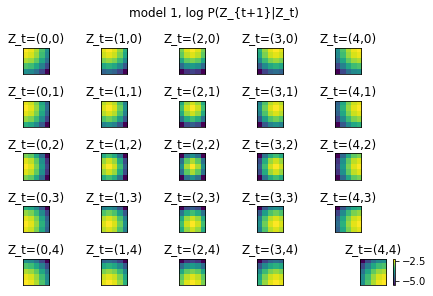

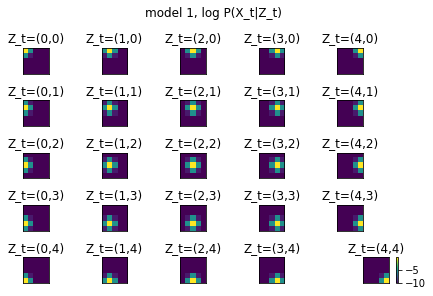

In [34]:
model = Tracker(size=5, # size of the grid world
                alpha=5, # how peaky the observation distribution is
                beta=0.1, # how peaky the transition distribution is
                epsilon=0.001 # probability of garbage sensor reading
)
visualize_spatial_probabilities(model, model.transition_distribution, "model 1, log P(Z_{t+1}|Z_t)")
visualize_spatial_probabilities(model, model.observation_distribution, "model 1, log P(X_t|Z_t)")

# Visualizing a tracker model's probability distributions (model 2)
The following code box will visualize the transition distribution $P(Z_{t+1}|Z_t)$ (top) followed by visualization of $P(X_t|Z_t)$ (bottom) for $\alpha=0.1$, $\beta=5$, $\epsilon=0.5$.

You should see a grid of heatmaps. Each heatmap is labelled with the value of $Z_t$. Each cell in the heatmap corresponds to a different value of either $Z_{t+1}$ (for the transition distribution, top grid) or $X_t$ (for the observation distribution, bottom grid).

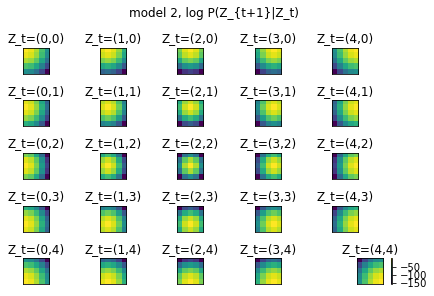

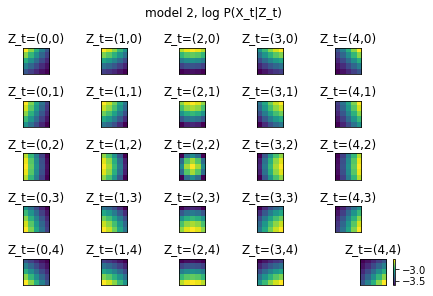

In [35]:
model = Tracker(size=5, # size of the grid world
                alpha=0.1, # how peaky the observation distribution is
                beta=5, # how peaky the transition distribution is
                epsilon=0.5 # probability of garbage sensor reading
)
visualize_spatial_probabilities(model, model.transition_distribution, "model 2, log P(Z_{t+1}|Z_t)")
visualize_spatial_probabilities(model, model.observation_distribution, "model 2, log P(X_t|Z_t)")

# Comparing visualizations

## Question 4.1 (2 pt)
Which parameter(s) cause the observation distributions to differ? Why is model 1's observation distribution more peaky? Pay attention to the scale of the heatmaps in the legends, and remember that these are log probabilities. 

* **Solution: The Alpha value in the second model was lowered causing it to report more spread out (diffused) probability distribution, compared to the first one. Additionally the Epsilon value for the second model was significantly higher than that in the first model which also drives down the probability and creates less peaky distributions for the observations.** 

## Question 4.2 (2 pt)
Which parameter(s) cause the transition distributions to differ? Which tracker model (1 or 2) has the more diffuse transition probabilities? 

* **Solution: We note that the Beta value in the second model was increased compared to the first one, meaning that the corresponding probability values in the transition probabilities will also be lower according to the formula. Snce the cells with colours close to yellow are more in the the second model, it means that probability values are spread out over a range of values as opposed to a single value, thus creating the diffuse pattern we see in the second model.** 

# Create an example trajectory on a 10x10 grid
The following code creates an example trajectory that first walks upward along the side of the grid world, and then walks rightward along the top of the grid world. The moving object starts at (0,0). The sensor readings are correct except for the first sensor reading, which erroneously reports the garbage value of (4,7).

In [12]:
size = 10
ground_truth = [(0,t) for t in range(0, size-1) ] + [(t,size-1) for t in range(size) ]
observations = list(ground_truth)
observations[0] = (4,7) # add a garbage sensor reading

# Visualize the inferred trajectory, using both forward and forward/backward, assuming sensor readings are sometimes garbage (epsilon=0.01)

forward has sum of squared error 83.4345138390606
forward_backward has sum of squared error 3.6674811426051006


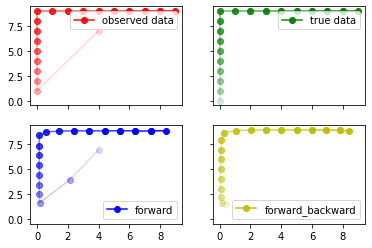

{'forward': 83.4345138390606, 'forward_backward': 3.6674811426051006}

In [13]:
visualize_inferred_trajectory(observations, ground_truth,
                              Tracker(size=10, alpha=1, beta=1, epsilon=0.01))

## Question 4.3 (2 pt)
Why is the forward estimate of the trajectory so incorrect at the beginning, and why does that inaccuracy not occur for forward/backward? 

**Solution:**

**We first note that the epsilon value is non zero in this case, implying that the model can accomodate garbage reading at some point in time, by shifting the probability distributions. This gives the model the capabability to correct for any erraneous initial position given and thus their probability values (using the second (epsilon) term in the likelihood probability equation). The forward algorithm estimates a posterior distribution using knowledge of prior states alone, thus in the beginning considering we have only an erraneous reading, it would have considerable effect in determining the probability of the current state with only some correction offered by the epsilon term. This is reflected by the algorithm choosing the garbage state at the beginning. With the forward backward algorithm however, the posterior distribution calculated by the foward algorithm is updated using future observation values via the backward algorithm as well. Along with the correction term for garbage reading in the likelihood distribution, this creates a probability correction effect that results in the final posterior distribution shifting towards the correct state at the beginning itself as dictated by the future correct observations we made.**

# Visualize the inferred trajectory, using both forward and forward/backward, assuming sensor readings are never garbage (epsilon=0.0)

forward has sum of squared error 76.39132958482841
forward_backward has sum of squared error 36.26021422441891


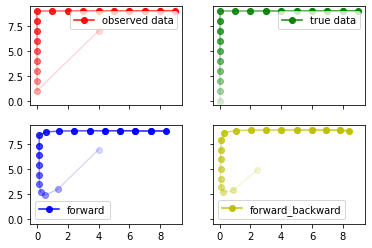

{'forward': 76.39132958482841, 'forward_backward': 36.26021422441891}

In [14]:
visualize_inferred_trajectory(observations, ground_truth,
                              Tracker(size=10, alpha=1, beta=1, epsilon=0.0))

## Question 4.4 (2 pt)
Why is the forward/backward estimate of the trajectory so incorrect at the beginning ($t=1$) when $\epsilon=0$, compared to $\epsilon=0.01$? Why is it still so incorrect at $t=2$?

**Solution:**                                                                                                                         

**Since Epsilon value was driven to zero in the second model, the implicit assumption carried by this model is that none of the sensor readings are garbage by nature. Thus the equation would apply higher likelihood probability for any observation it reads. Given that our first state is actually a garbage reading, the posterior probability distribution captured by the forward backward algorithm would have no 'correction' effect offered by the epsilon term; the posterior developed by the forward is updated by the backward, with no further enhancement to the distribution. This is in stark contrast to the first model where we observe an additional correction effect offered in the likelihood probability calculation by the epsilon term. Thus the second model fails to capture a more refined posterior compared to the first leading the algorithm to choose a wrong state in the beginning. We note that instead of a (4,7) coordinate (chosen by the forward algo) the forward backward chooses a more closeer cooordinate to the correct states, consistent with the future correct states and with the lower transition probabilities. The lower transitioon probabilities (characterized by the Beta term), gives an inertial edge to the model and thus we see only a smaller progression to the correct states (along the boundary) consistent with the future, which is why we still see incorrect readings even at time =2.** 

# Analyze the average error using both the forward and forward/backward algorithm
The below code simulates 100 random trajectories, uses your inference methods to predict the trajectory, and builds analyses the sum of squared errors between the true trajectory and  the predicted trajectory at each time point. We are interested comparing the forward and forward/backward algorithm, so we build a histogram of the difference between the forward/backward error and the forward error (negative numbers mean that forward/backward is better).
The vertical line shows the average of this difference.

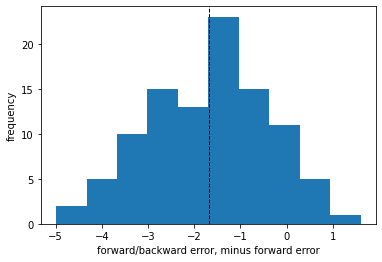

In [67]:
model = Tracker(size=5, # size of the grid world
                alpha=2, # how peaky the observation distribution is
                beta=2, # how peaky the transition distribution is
                epsilon=0.01 # probability of garbage sensor reading
)

    
difference_in_errors = []
for s in range(100):
    np.random.seed(s)
    ground_truth, observations=model.sample_from_model(20)
    errors = analyze_errors(observations, ground_truth, model)

    difference_in_errors.append(errors["forward_backward"]-errors["forward"])

plt.figure()
plt.hist(difference_in_errors)
plt.xlabel("forward/backward error, minus forward error")
plt.ylabel("frequency")
plt.axvline(np.array(difference_in_errors).mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

## Question 4.5 (4 pt)
You should see that on average forward/backward is more accurate. What is a real world example of tracking a moving object where you would use forward/backward? What is a real world example of tracking a moving object where you would use forward instead? 

Solution: 

**Forwards/Filters : Vehicle Localization given prior location coordinates can allude to real world example of an object tracking system using Bayesian filters/forwards estimation procedure. Here the transition model, denoting how the vehicle position changes over time with velocity, P(Z_t+1/Z_t) is a function of the initial state and the velocity of the moving object. The measurement model i.e. P(X_t/Z_t) is produced using a GPS coordinate tracking system.Thus we estimate the actual position of the vehicle at any time given its GPS coordinates (measurements) till that time, i.e. P(Z_t/X_1:t) using a forward algorithm. We can further assume that both the measurement and transition model have errors associated with them (Gaussian noises). If we were to assume a linear model for these conditional probabilitites with measurements and transitions denote by normal random variates, we achieve a more tractable system of equations that is likened to a real world tracking system (the algorithm then becomes the standard Kalman Filter).**

**Forward-Backward/Smoothing: Estimating a projectile/missile launch position given entire history of radar readings is an example where smoothing algorithm can be effectively employed. The transition model explains how the missle travels through its trajectory, i.e. it gives us its position coordinates Z_t at any time via velocity and time measurements. Similarly radar readings gives us measurements in this case i.e X_t. With a history of radar readings X_1:T we can infer the actual poisition coordinate at time t Z_t by using the forward backward algorithm. i.e we compute the conditional probability P(Z_t/X_1:T) using both the forward and backward algorithm.** 

# Benchmark the scaling behavior of your inference algorithms
The below code simulates 100 random trajectories of length between 1..100, and benchmarks the runtime of your forward, backward, and forward/backward inference methods.

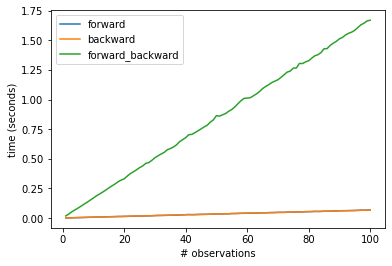

In [68]:
def benchmark_inference(hmm):

    forward_time, backward_time, forward_backward_time = [], [], []
    
    for t in range(1, 100+1):
        ground_truth, observations = hmm.sample_from_model(t)
        hmm.forward_dynamic_programming = {}
        hmm.backward_dynamic_programming = {}

        start_time = time()
        hmm.forward(observations)
        total_time = time() - start_time
        
        forward_time.append(total_time)

        hmm.forward_dynamic_programming = {}
        hmm.backward_dynamic_programming = {}
        start_time = time()
        hmm.backward(observations)
        total_time = time() - start_time
        
        backward_time.append(total_time)

        hmm.forward_dynamic_programming = {}
        hmm.backward_dynamic_programming = {}
        start_time = time()
        hmm.forward_backward(observations, max(1, t//2))
        total_time = time() - start_time
        
        forward_backward_time.append(total_time)

    
    plt.figure()
    plt.plot(np.arange(len(forward_time))+1,
             np.array(forward_time),
             label="forward")
    plt.plot(np.arange(len(backward_time))+1,
             np.array(backward_time),
             label="backward")
    plt.plot(np.arange(len(forward_backward_time))+1,
             np.array(forward_backward_time),
             label="forward_backward")
    plt.legend()
    plt.xlabel("# observations")
    plt.ylabel("time (seconds)")
    plt.show()
benchmark_inference(model)

## Question 4.6 (1 pt)
What is the big-O time complexity of these methods? 

Solution: 

**Forward : We run the marginalization (summation) for each value of Z_t = S - statespace. But we have T such values for Z and recursively we have to perform this computation for T times. Therefore the order of time complexity is $ST^2$** 

**Backward : We run the marginalization (summation) for each value of Z_t = S - statespace. But we have T such values for Z and recursively we have to perform this computation for T times. Therefore the order of time complexity is $ST^2$** 

**Forward Backward : Since we multiply (or add if log) the forward and backward algorithms simultaneously, the time complexity of the Forward Backward also remains the same as that of either Forward or Backward at order $ST^2$** 

# Heartrate wakefulness model

You will be working with a HMM for monitoring heart rate (the observed data) and inferring if the patient is awake or asleep (the hidden state). Time is measured in hours, and is discrete. **Heart rate is a continuous random variable.**

The hidden state at each time point is whether the patient is awake or asleep:
$$Z_t\in \{\text{awake}, \text{sleeping}\}$$

The observation at each time point is the heartrate:
$$X_t\in \mathbb{R}$$

Heart rate is distributed according to a normal (Gaussian) distribution, but the mean and standard deviation of this normal distribution depends on the hidden state according to the parameters $\mu_\text{sleep}, \sigma_\text{sleep}, \mu_\text{awake}, \sigma_\text{awake}$:
$$p(X_t|Z_t=\text{sleeping})=\frac{1}{\sigma_\text{sleep}\sqrt{2\pi}}\exp\left(\frac{1}{2}\left( \frac{X_t-\mu_\text{sleep}}{\sigma_\text{sleep}} \right)^2  \right)$$
$$p(X_t|Z_t=\text{awake})=\frac{1}{\sigma_\text{awake}\sqrt{2\pi}}\exp\left(\frac{1}{2}\left( \frac{X_t-\mu_\text{awake}}{\sigma_\text{awake}} \right)^2  \right)$$

With probability $p_\text{awaken}$, the patient wakes up after each hour spent sleeping:
$$P(Z_t=\text{awake}|Z_t=\text{sleeping})=p_\text{awaken}$$
$$P(Z_t=\text{sleeping}|Z_t=\text{sleeping})=1-p_\text{awaken}$$

With probability $p_\text{sleep}$, the patient falls asleep after each hour spent awake:
$$P(Z_t=\text{sleeping}|Z_t=\text{awake})=p_\text{sleep}$$
$$P(Z_t=\text{awake}|Z_t=\text{awake})=1-p_\text{sleep}$$

Apriori, the patient is equally likely to be awake or asleep at the initial time step:
$$P(Z_1=\text{sleeping})=\frac{1}{2}$$
$$P(Z_1=\text{awake})=\frac{1}{2}$$

## Task 5.1 Implement the constructor (2 pt)
Implement the constructor of `SleepHeartRate`. You should calculate and set `transition_distribution` and `initial_distribution`.

## Task 5.2 Implement `logProb_observation_given_state` (2 pt)
Implement the method `logProb_observation_given_state`. Should return the logarithm of the probability density $p(X_t|Z_t)$.

## Task 5.3 Implement `sample_observation_given_state` (2 pt)
Implement the method `sample_observation_given_state` using `np.random.normal`, whose documentation is [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)

In [44]:
from math import pi

class SleepHeartRate(HMM):
    def __init__(self, mu_sleep, mu_awake, sigma_sleep, sigma_awake,
                 p_awaken, p_sleep):
        """
        mu_sleep: average heart rate, sleeping
        mu_awake: average heart rate, awake
        sigma_sleep: standard deviation of heart rate, sleeping
        sigma_awake: standard deviation of heart rate, awake
        p_awaken: probability of waking up when asleep (per hour)
        p_sleep: probability of falling asleep when awake (per hour)
        """

        self.mu_sleep, self.mu_awake, self.sigma_sleep, self.sigma_awake = \
                       mu_sleep, mu_awake, sigma_sleep, sigma_awake

        state_space = ["sleeping", "awake"]

        # Populate `transition_distribution` so that transition_distribution[s1][s2]=log P(Z_{t+1}=s2|Z_t=s1)
        # s1, s2 should be either "sleeping" or "awake"
        transition_distribution = {}
        transition_distribution[state_space[0]]=norm_log_distribution({state_space[0]:log(1- p_awaken), state_space[1]:log(p_awaken) })
        transition_distribution[state_space[1]]=norm_log_distribution({state_space[0] :log(p_sleep), state_space[1]:log(1-p_sleep) })
        #assert False, "implement as part of homework"
        
        # Populate `initial_state_distribution` such that initial_state_distribution[z]=log P(Z_1=z)
        # z should be either "sleeping" or "awake"
        initial_state_distribution = {}
        initial_state_distribution[state_space[0]] = log(0.5)
        initial_state_distribution[state_space[1]] = log(0.5)
        #assert False, "implement as part of homework"
        
        super().__init__(state_space, transition_distribution, initial_state_distribution)  
    
        # Populate `self.observation_distribution` so that self.observation_distribution[z][x]=log P(X_t=x|Z_t=z) 
   
    def observation_distribution(self, state, observation):
        if state == 'sleeping':
            return log((1/(self.sigma_sleep * math.sqrt(2*math.pi)))*math.exp(-0.5*((observation-self.mu_sleep)/(self.sigma_sleep))**2))
        else:
            return log((1/(self.sigma_awake * math.sqrt(2*math.pi)))*math.exp(-0.5*((observation-self.mu_awake)/(self.sigma_awake))**2))
    
    def forward(self,observations):
        self.forward_dynamic_programming[1]={}
        for s in self.state_space:
            self.forward_dynamic_programming[1][s] = self.observation_distribution(s,observations[0]) + self.initial_state_distribution[s]

        for i in range(2,len(observations)+1):
            self.forward_dynamic_programming[i]={}
            for s in self.state_space:
                self.forward_dynamic_programming[i][s] = log_sum_exp_list([(self.observation_distribution(s,observations[i-1]) + self.transition_distribution[Z_iminus][s] + self.forward_dynamic_programming[i-1][Z_iminus]) for Z_iminus in self.state_space]) 
        return self.forward_dynamic_programming[len(observations)]
    
    def backward(self,observations):
        self.backward_dynamic_programming[len(observations)+1]={}
        for s in self.state_space:
            self.backward_dynamic_programming[len(observations)+1][s] = 0

        for i in range(len(observations),0,-1):
            self.backward_dynamic_programming[i]={}
            for s in self.state_space:
                self.backward_dynamic_programming[i][s] = log_sum_exp_list([(self.observation_distribution(Z_iplus,observations[i-1])  + self.transition_distribution[s][Z_iplus] + self.backward_dynamic_programming[i+1][Z_iplus]) for Z_iplus in self.state_space]) 
        return self.backward_dynamic_programming[1]

    def logProb_observation_given_state(self, observation, state):
        """
        calculates log p(observation_t | state_t)
        """
        log_prob_obs_giv_state = log(self.observation_distribution[state][observation])
        return log_prob_obs_giv_state
        #assert False, "implement as part of homework"

    def sample_observation_given_state(self, state):
        """
        stochastically draws a sample from P(observation_t | state_t)
        """
        if state == "sleeping":
            s = np.random.normal(self.mu_sleep, self.sigma_sleep, 1)
        else:
            s = np.random.normal(self.mu_awake, self.sigma_awake, 1)
        return s
        #assert False, "implement as part of homework"

# Analysis code for heart rate model

In [45]:
def analyze_model_predictions(ground_truth, observations, model,
                              visualize=True):
    T = len(observations)
    assert T == len(ground_truth)

    ground_truth = [(gt=="awake")*1. for gt in ground_truth ]

    if visualize:
        fig, ax1 = plt.subplots()
        ax1.set_xlabel('time (hr)')
        ax1.set_ylabel('beats per minute', color="b")
        ax1.plot(observations, label="heart rate", color="b")

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_ylabel('Probability Awake?')  # we already handled the x-label with ax1
        ax2.plot(ground_truth, color="r", label="ground truth")

    errors = {}

    for inference_method in ["forward", "forward_backward"]:
        
        inferred_trajectory = []
        for t in range(1, 1+len(observations)):
            if inference_method == "forward":
                distribution = model.forward(observations[:t])
            elif inference_method == "forward_backward":
                distribution = model.forward_backward(observations, t)
            
            expected_awake = expectation(distribution, lambda state: 1.*(state=="awake"))
            inferred_trajectory.append(expected_awake)
        
        errors[inference_method] = sum( (a-ah)**2 
                                        for a, ah in zip(ground_truth, inferred_trajectory) )
        if visualize:
            print(inference_method, "has sum of squared error", errors[inference_method])
            ax2.plot(inferred_trajectory, label=inference_method)
            

    
    if visualize:
        ax2.legend()
        plt.show()

    return errors

# Create a heart rate model, simulate random data, and run both forward and forward/backward inference

forward has sum of squared error 0.6095462601420154
forward_backward has sum of squared error 0.019301833271526313


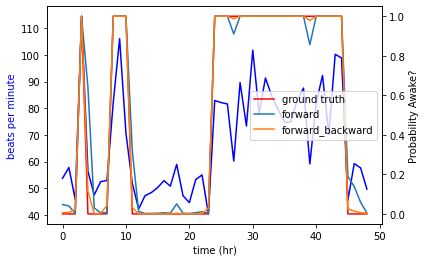

{'forward': 0.6095462601420154, 'forward_backward': 0.019301833271526313}

In [7]:
model = SleepHeartRate(50., # average heart rate, sleeping
                       85., # average heart rate, awake
                       5.,  # standard deviation of heart rate, sleeping
                       15., # standard deviation of heart rate, awake
                       1/8., # probability of waking up when asleep (per hour)
                       1/16. # probability of falling asleep when awake (per hour)
)
np.random.seed(0)
ground_truth, observations=model.sample_from_model(48)
analyze_model_predictions(ground_truth, observations, model)

## Question 6.1 (2 pt)
You should notice at least one long run of the patient being awake. You should also notice that the forward/backward algorithm "jumps the gun" and starts predicting a small probability of wakefulness before actually the patient is awake. Why does this happen?

**Solution:** 

**We first note the transition probabilities of waking up when asleep(1/8) is almost twice as large as falling asleep when awake(1/16). We can infer that there is larger inertia for an awaken man to stay awake than there is for a sleeping man to stay asleep.Now considering how the forward backward algorithm makes posterior estimations of awakeness based on future observations, the higher inertia of staying awake will cause the graph to show a small jump in probability even before the man is awake to accomodate the inertial effect.** 

# Analyze the average error using both the forward and forward/backward algorithm

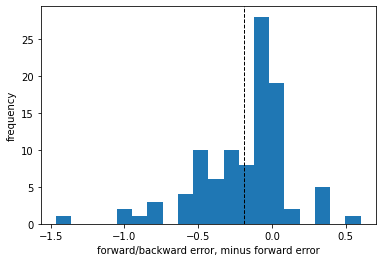

In [38]:
difference_in_errors = []
for s in range(100):
    np.random.seed(s)
    ground_truth, observations=model.sample_from_model(20)
    errors = analyze_model_predictions(ground_truth, observations, model, visualize=False)

    difference_in_errors.append(errors["forward_backward"]-errors["forward"])

plt.figure()
plt.hist(difference_in_errors, bins=20)
plt.xlabel("forward/backward error, minus forward error")
plt.ylabel("frequency")
plt.axvline(np.array(difference_in_errors).mean(), color='k', linestyle='dashed', linewidth=1)
plt.show()

## Question 6.2 (4 pt) 
You should see that on average forward/backward is more accurate. What is a real world example of monitoring heart rate and inferring wakefulness where you would use forward/backward? What is a real world example in this scenario where you would use forward instead? 

**Solution:** 

**We use forward backward algorithm in understanding sleep disorders in patients; sleep apnea that keeps patients awake at night is strongly correlated with breathing/heart rates and therefore monitoring the exact times of being awake during the night is crucial. Often times posterior estimations of forward estimates helps give us a more exact distribution of the wakefultimes hence the use for forward backward algorithm.**

**Denoising ECG readings used to track cardiorespiratory signals for sleep/wake state efffectively employs bayesian filters based on the concept of forward estimations.**

# A mystery heartrate data set for you to analyze
We have generated a dataset -- but this dataset was generated from a patient with a unknown sleeping heartrate $\mu_\text{sleep}$, which you will have to infer. You can assume
$\sigma_\text{sleep}=5, \mu_\text{awake}=85, \sigma_\text{awake}=15, p_\text{awaken}=1/8, p_\text{sleep}=1/16$.

In [46]:
data = [60.024586292581, 52.3718697759278, 58.80170020585246, 67.11909523460665, 49.8754588478012, 65.14986012024706, 64.24568967142685, 100.04802032130739, 99.8591886252985, 81.5722175046971, 98.15841662729339, 94.52084751694113, 69.18268915795875, 55.57529555049684, 58.5367056334972, 71.17802518532243, 99.45343945778617, 110.00871336445333, 65.87609719134765, 73.49688388469505, 75.14999745087842, 62.83556592039949, 62.24268945549414, 50.64006868902254, 58.68316622316542, 58.76844539881316, 44.70217969599618, 53.20784968688581, 59.6254161863151, 52.73053617276515, 91.46946843489923, 67.56155611791766, 96.00146670782686, 93.16447851190654, 80.33287865068364, 87.14571434632957, 68.70089221350426, 80.60219494419252, 65.94141431130146, 96.37328628188756, 55.11221509740634, 51.2383376346944, 56.65657395145553, 60.49329228703645, 50.386167344456574, 58.28615586781797, 59.037250815880824, 52.947108422631445, 60.45578535635233, 52.80251226623432, 46.75169525578589, 57.22571676296071, 57.52007078129511, 61.60973314211153, 57.34122092576476, 55.89793390034725, 52.01143792919454, 54.980726069973045, 65.70825104401858, 63.02214790547422, 52.383937679940246, 68.46791656760132, 50.5208261485005, 56.596465482996926, 50.46997663314116, 52.18782319819992, 47.75103007441167, 52.16949896921022, 54.72292078866861, 60.91076777688642, 66.73557016014277, 51.788437149295, 47.9436462280157, 58.17907883132434, 58.116637693881735, 74.47731618079851, 72.00486966527343, 71.44157933564942, 51.351651546480895, 48.59728122511345, 48.51399586787, 59.98179888718437, 52.5981219814829, 51.405716498380116, 55.039190955042805, 61.0988621629985, 82.64547636716155, 88.78430366800575, 82.37630040728104, 71.97660245392298, 80.54323815406585, 109.64690694799344, 105.35659649433344, 104.9638969131752, 93.7568541513724, 92.7414755052842, 70.81475837717642, 99.9090452664229, 95.25439425732922, 84.1307548628451, 104.82574081316936, 81.96191274406061, 70.86757270765774, 74.41525964799092, 85.79120242387785, 86.1332117596878, 100.7678626743189, 90.01624012160912, 71.7884040795559, 70.73359696143602, 101.20891696064376, 67.29279483976377, 93.96488663365152, 89.00692866991777, 86.50565099080158, 94.16774529814853, 68.46851293124942, 50.31707874861571, 95.48121164553594, 93.3282366893721, 107.58874005602294, 74.26097918643995, 108.58480530604129, 65.30861662737179, 68.2582493593002, 105.57462867649608, 89.34729173581606, 90.17579760799975, 63.754670231991454, 92.93975937886121, 60.30811678140145, 52.018810065895956, 59.65207940890939, 52.44195306378311, 50.44592662162375, 60.77384356589032, 95.00224569796306, 63.05121895867677, 56.33014259948891, 64.57639305225467, 96.9959748510934, 83.59908000182357, 77.69382924661042, 91.86627110283584, 90.4049936295561, 99.47473788932902, 66.10634898740406, 118.80472907658842, 100.75677458241091, 88.2343328762152, 71.874381123758, 108.6305918624782, 56.70109221698572, 55.44656624810501, 56.864066289101864, 52.4095087326326, 58.11733066507287, 60.38281252479621, 61.122670007845926, 81.03674262733746, 100.2212207602823, 84.09680007042657, 51.25870284998918, 46.22507411109206, 56.931820829501596, 48.204974739723156, 48.86145443933335, 102.57440152785577, 54.05309659353633, 53.34568876774659, 80.7273980640838, 95.59286161718398, 77.88622665296381, 82.40312847033421, 108.00156058411162, 81.90258450297034, 74.1424824500362, 78.42103682348184, 79.49607574109665, 87.94096191621301, 84.05112114463488, 70.03983307606197, 96.88259300600808, 89.19818739612077, 90.34309722760493, 55.85955559057182, 55.561348883547666, 56.21942910813162, 62.65734767196688, 91.81887482725234, 87.14927267146705, 79.60907688266254, 92.8416840816192, 77.54922167157379, 92.38062636596855, 108.69096015624399, 62.46034405153159, 76.87859491768087, 84.1845484157788, 90.13390354517759, 62.41964107344813, 87.89317766344834, 53.95283286979039, 85.74609210621546, 78.8456726565378, 110.96926715915241, 78.68033912662743, 97.30225960808389, 110.74538847351698, 77.71722971641593, 93.01482784188605, 118.1580589938144, 61.16943822368874, 92.40224715512375, 113.88047023655719, 77.42430300423602, 91.3856464843722, 112.1463012616061, 69.20660687884333, 75.2474826323996, 51.67908547001017, 49.496102817092705, 58.35683262150556, 56.597154491810606, 62.576894102206296, 44.382660204462, 55.12491945581128, 59.45083658054802, 45.460929928686205, 59.850429145895575, 52.301922385277955, 50.56818128833715, 54.03572641501221, 53.91969524630194, 51.700234165529395, 55.41156912571518, 63.475033661833294, 58.64556459921754, 51.88113967789142, 47.201143524742875]


# Calculate the prior, likelihood, and posterior over the sleeping heart rate, given the mystery dataset

Assume that we think that the sleeping heart rate is between $40$ and $65$ beats per minute, but that it is probably around $45$.

We are going to quantize the sleeping heart rate:
$\mu_\text{sleep}\in \left\{ 40, 41, 42, \cdots, 65 \right\}$. In the code below, `possible_sleeping_heart_rates` contains the list of possible sleeping heart rates.

In [47]:
possible_sleeping_heart_rates = list(range(40, 65+1))

## Task 7.1 Code the prior over $\mu_\text{sleep}$ (1pt)
Assume this prior distribution over $\mu_\text{sleep}$:
$$P(\mu_\text{sleep})\propto 1\left[ \mu_\text{sleep}\in \left\{ 40, 41, 42, \cdots, 65 \right\} \right]\times\exp\left( -|\mu_\text{sleep}-45| \right)$$
Calculate `log_prior`, which should be a dictionary mapping $\mu_\text{sleep}$ to $\log P(\mu_\text{sleep})$. It should be normalized.

In [48]:
# log_prior[hr] = log P(mu_sleep=hr), whenever hr is a member of possible_sleeping_heart_rates
log_prior = {} 

for i in possible_sleeping_heart_rates :
    log_prior[i] = log(math.exp(-abs(i - 45)))

log_prior = norm_log_distribution(log_prior)
# calculate this as part of homework

# Check that it is normalized
normalizing_constant = log_sum_exp_list(list(log_prior.values()))
if abs(normalizing_constant)>1e-5:
    assert False, f"Your prior over sleeping heart rates is not normalized. Remembered that it should contain log probabilities."

## Task 7.2 Code the likelihood of the mystery data given $\mu_\text{sleep}$ (5pt)
Assume this likelihood:
$$P(X_{1:T}|\mu_\text{sleep})=\sum_{Z_{1:T}}P(X_{1:T}, Z_{1:T}|\mu_\text{sleep}, \sigma_\text{sleep}=5, \mu_\text{awake}=85, \sigma_\text{awake}=15, p_\text{awaken}=1/8, p_\text{sleep}=1/16)
$$
where $X_{1:T}$ is the mystery data, stored in the variable `data`.

Calculate `log_likelihood`, which should be a dictionary mapping $\mu_\text{sleep}$ to $\log P(X_{1:T}|\mu_\text{sleep})$.
You should use the `.marginal_likelihood` method that you defined in the `HMM` class.

In [49]:
# log_likelihood[hr] = log P(data|mu_sleep=hr), whenever hr is a member of possible_sleeping_heart_rates

log_likelihood = {}

for i in possible_sleeping_heart_rates :
    model_2 = SleepHeartRate(i, # average heart rate, sleeping
                       85., # average heart rate, awake
                       5.,  # standard deviation of heart rate, sleeping
                       15., # standard deviation of heart rate, awake
                       1/8., # probability of waking up when asleep (per hour)
                       1/16. # probability of falling asleep when awake (per hour)
)
    log_likelihood[i] = model_2.marginal_likelihood(data)
    #log_likelihood[i] =0
    #for j in data:       
        #log_likelihood[i] = log_likelihood[i] + log((1/(5 * math.sqrt(2*math.pi)))*math.exp(-0.5*((j-i)/(5))**2) * (1/(15 * math.sqrt(2*math.pi)))*math.exp(-0.5*((j-85)/(15))**2))


# implement as part of homework

## Task 7.3 Code the posterior over $\mu_\text{sleep}$ given the mystery data (2pt)
By Bayes theorem, the posterior $P(\mu_\text{sleep}|X_{1:T})$ is
$$
P(\mu_\text{sleep}|X_{1:T})\propto P(X_{1:T}|\mu_\text{sleep})P(\mu_\text{sleep})
$$
where $X_{1:T}$ is the mystery data.

Calculate `log_posterior`, which should be a dictionary mapping $\mu_\text{sleep}$ to $\log P(\mu_\text{sleep}|X_{1:T})$. It should be normalized.

In [50]:
# log_posterior[hr] = log P(mu_sleep=hr|data), whenever hr is a member of possible_sleeping_heart_rates
log_posterior =  {}

for i in possible_sleeping_heart_rates:
        log_posterior[i] = log_likelihood[i] + log_prior[i]

log_posterior = norm_log_distribution(log_posterior)        
# implement as part of homework

# Checked that it is normalized
normalizing_constant = log_sum_exp_list(list(log_posterior.values()))
if abs(normalizing_constant)>1e-5:
    assert False, f"Your posterior over sleeping heart rates is not normalized. Remembered that it should contain log probabilities."

# Visualize the prior, likelihood, and posterior

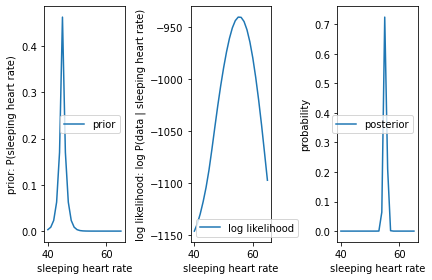

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=False)
ax1.plot(possible_sleeping_heart_rates,
         [exp(log_prior[hr]) for hr in possible_sleeping_heart_rates ],
         label="prior")
ax1.set_xlabel("sleeping heart rate")
ax1.set_ylabel("prior: P(sleeping heart rate)")
ax1.legend()
ax2.plot(possible_sleeping_heart_rates,
         [log_likelihood[hr] for hr in possible_sleeping_heart_rates ],
         label="log likelihood")
ax2.set_xlabel("sleeping heart rate")
ax2.set_ylabel("log likelihood: log P(data | sleeping heart rate)")
ax2.legend()
ax3.plot(possible_sleeping_heart_rates,
         [exp(log_posterior[hr]) for hr in possible_sleeping_heart_rates ],
         label="posterior")
ax3.legend()
ax3.set_xlabel("sleeping heart rate")
ax3.set_ylabel("posterior: P(sleeping heart rate | data)")
plt.ylabel("probability")
plt.tight_layout()
plt.show()

## Question 7.4 (2pt)
What is the most likely value of sleeping heart rate, conditioned on the data? Write a very small amount of code below that will print it out, and compute it from `log_posterior`.

In [52]:
print(max(log_posterior, key=log_posterior.get), # put your calculation here as part of the homework
      "beats per minute")

55 beats per minute


## Question 7.5 (2pt) 
What is the value of sleeping heart rate that assigns the highest probability to the data? Write a very small amount of code below that will print it out, and compute it from `log_likelihood`.

In [53]:
print(max(log_likelihood, key=log_likelihood.get), # put your calculation here as part of the homework
      "beats per minute")

55 beats per minute


## Question 7.6 (1pt) 
Why are these previous two values the same, or at least very close? Appeal to general principles of Bayesian inference

**Solution: We note that the prior, apart from a minor peak in probability for a certain data, remains relatively uniform throughout. Thus the likelihood dominates the posterior distribution and since it achieves a maximum in close vicinity to the probability peak for the prior, we find the maximum of the posterior ranging close to the maximum of the likelihood.** 